In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Nov 12 01:09:17 2016

@author: stephen
"""
import sys

sys.path.append("../")
import utils
import time
from tensorflow import keras
# from keras.callbacks import EarlyStopping

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(813306)

start = time.time()


def build_resnet(input_shape, n_feature_maps, nb_classes):
    print("build conv_x")
    x = keras.layers.Input(shape=(input_shape))
    conv_x = keras.layers.BatchNormalization()(x)
    conv_x = keras.layers.Conv2D(n_feature_maps, 8, 1, padding="same")(conv_x)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation("relu")(conv_x)

    print("build conv_y")
    conv_y = keras.layers.Conv2D(n_feature_maps, 5, 1, padding="same")(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation("relu")(conv_y)

    print("build conv_z")
    conv_z = keras.layers.Conv2D(n_feature_maps, 3, 1, padding="same")(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    is_expand_channels = not (input_shape[-1] == n_feature_maps)
    if is_expand_channels:
        shortcut_y = keras.layers.Conv2D(n_feature_maps, 1, 1, padding="same")(x)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = keras.layers.BatchNormalization()(x)
    print("Merging skip connection")
    y = keras.layers.Add()([shortcut_y, conv_z])
    y = keras.layers.Activation("relu")(y)

    print("build conv_x")
    x1 = y
    conv_x = keras.layers.Conv2D(n_feature_maps * 2, 8, 1, padding="same")(x1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation("relu")(conv_x)

    print("build conv_y")
    conv_y = keras.layers.Conv2D(n_feature_maps * 2, 5, 1, padding="same")(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation("relu")(conv_y)

    print("build conv_z")
    conv_z = keras.layers.Conv2D(n_feature_maps * 2, 3, 1, padding="same")(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    is_expand_channels = not (input_shape[-1] == n_feature_maps * 2)
    if is_expand_channels:
        shortcut_y = keras.layers.Conv2D(n_feature_maps * 2, 1, 1, padding="same")(x1)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = keras.layers.BatchNormalization()(x1)
    print("Merging skip connection")
    y = keras.layers.Add()([shortcut_y, conv_z])
    y = keras.layers.Activation("relu")(y)

    print("build conv_x")
    x1 = y
    conv_x = keras.layers.Conv2D(n_feature_maps * 2, 8, 1, padding="same")(x1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation("relu")(conv_x)

    print("build conv_y")
    conv_y = keras.layers.Conv2D(n_feature_maps * 2, 5, 1, padding="same")(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation("relu")(conv_y)

    print("build conv_z")
    conv_z = keras.layers.Conv2D(n_feature_maps * 2, 3, 1, padding="same")(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    is_expand_channels = not (input_shape[-1] == n_feature_maps * 2)
    if is_expand_channels:
        shortcut_y = keras.layers.Conv2D(n_feature_maps * 2, 1, 1, padding="same")(x1)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = keras.layers.BatchNormalization()(x1)
    print("Merging skip connection")
    y = keras.layers.Add()([shortcut_y, conv_z])
    y = keras.layers.Activation("relu")(y)

    full = keras.layers.GlobalAveragePooling2D()(y)
    out = keras.layers.Dense(nb_classes, activation="softmax")(full)
    print("        -- model was built.")
    return x, out


def readucr(filename):
    data = np.loadtxt(filename)
    Y = data[:, 0]
    X = data[:, 1:]
    return X, Y


epochs = 1500

flist = ["../../datasets/GunPoint/GunPoint"]

for each in flist:
    fname = each
    x_train, y_train = readucr(fname + "_TRAIN.txt")
    x_test, y_test = readucr(fname + "_TEST.txt")
    nb_classes = len(np.unique(y_test))
    batch_size = int(min(x_train.shape[0] / 10, 16))

    y_train = (
        (y_train - y_train.min()) / (y_train.max() - y_train.min()) * (nb_classes - 1)
    )
    y_test = (y_test - y_test.min()) / (y_test.max() - y_test.min()) * (nb_classes - 1)

    Y_train = keras.utils.to_categorical(y_train, nb_classes)
    Y_test = keras.utils.to_categorical(y_test, nb_classes)

    x_train_mean = x_train.mean()
    x_train_std = x_train.std()
    x_train = (x_train - x_train_mean) / (x_train_std)

    x_test = (x_test - x_train_mean) / (x_train_std)
    x_train = x_train.reshape(
        x_train.shape
        + (
            1,
            1,
        )
    )
    x_test = x_test.reshape(
        x_test.shape
        + (
            1,
            1,
        )
    )

    x, y = build_resnet(x_train.shape[1:], 64, nb_classes)
    model = keras.models.Model(inputs=x, outputs=y)
    optimizer = keras.optimizers.Adam()
    model.compile(
        loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
    )

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="loss", factor=0.5, patience=50, min_lr=0.0001
    )
    # es = EarlyStopping(monitor="val_loss", verbose=1, min_delta=1e-6, patience=200)

    hist = model.fit(
        x_train,
        Y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(x_test, Y_test),
        callbacks=[
            reduce_lr,
            # es
        ],
    )

elapsed_time = time.time() - start
model.save("../data/ResNet.h5")

build conv_x
build conv_y
build conv_z
Merging skip connection
build conv_x
build conv_y
build conv_z
Merging skip connection
build conv_x
build conv_y
build conv_z
Merging skip connection
        -- model was built.
Epoch 1/1500
10/10 [==============================] - 12s 664ms/step - loss: 0.8274 - accuracy: 0.6200 - val_loss: 0.6874 - val_accuracy: 0.4933 - lr: 0.0010
Epoch 2/1500
10/10 [==============================] - 5s 474ms/step - loss: 0.5930 - accuracy: 0.6800 - val_loss: 0.6847 - val_accuracy: 0.4933 - lr: 0.0010
Epoch 3/1500
10/10 [==============================] - 6s 604ms/step - loss: 0.5539 - accuracy: 0.7000 - val_loss: 0.6954 - val_accuracy: 0.4933 - lr: 0.0010
Epoch 4/1500
10/10 [==============================] - 5s 572ms/step - loss: 0.4985 - accuracy: 0.7800 - val_loss: 0.6970 - val_accuracy: 0.4933 - lr: 0.0010
Epoch 5/1500
10/10 [==============================] - 6s 636ms/step - loss: 0.4080 - accuracy: 0.8600 - val_loss: 0.7037 - val_accuracy: 0.5000 - lr: 0.00

10/10 [==============================] - 7s 740ms/step - loss: 0.1399 - accuracy: 0.9200 - val_loss: 0.2127 - val_accuracy: 0.9133 - lr: 0.0010
Epoch 52/1500
10/10 [==============================] - 7s 750ms/step - loss: 0.1336 - accuracy: 0.9400 - val_loss: 0.6409 - val_accuracy: 0.7267 - lr: 0.0010
Epoch 53/1500
10/10 [==============================] - 7s 751ms/step - loss: 0.0669 - accuracy: 0.9800 - val_loss: 0.6510 - val_accuracy: 0.7133 - lr: 0.0010
Epoch 54/1500
10/10 [==============================] - 7s 777ms/step - loss: 0.1535 - accuracy: 0.9200 - val_loss: 0.2763 - val_accuracy: 0.8467 - lr: 0.0010
Epoch 55/1500
10/10 [==============================] - 7s 749ms/step - loss: 0.0554 - accuracy: 0.9800 - val_loss: 0.0948 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 56/1500
10/10 [==============================] - 7s 754ms/step - loss: 0.0895 - accuracy: 0.9600 - val_loss: 0.2382 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 57/1500
10/10 [==============================] - 7s 757ms/st

Epoch 103/1500
10/10 [==============================] - 7s 769ms/step - loss: 0.0815 - accuracy: 0.9600 - val_loss: 0.1353 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 104/1500
10/10 [==============================] - 8s 783ms/step - loss: 0.0814 - accuracy: 0.9800 - val_loss: 0.0810 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 105/1500
10/10 [==============================] - 7s 789ms/step - loss: 0.0855 - accuracy: 0.9600 - val_loss: 0.0468 - val_accuracy: 0.9867 - lr: 0.0010
Epoch 106/1500
10/10 [==============================] - 7s 778ms/step - loss: 0.0281 - accuracy: 1.0000 - val_loss: 0.0282 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 107/1500
10/10 [==============================] - 7s 749ms/step - loss: 0.0162 - accuracy: 1.0000 - val_loss: 0.0479 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 108/1500
10/10 [==============================] - 7s 707ms/step - loss: 0.0115 - accuracy: 1.0000 - val_loss: 0.1308 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 109/1500
10/10 [========================

Epoch 154/1500
10/10 [==============================] - 7s 766ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0187 - val_accuracy: 0.9867 - lr: 5.0000e-04
Epoch 155/1500
10/10 [==============================] - 7s 767ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0191 - val_accuracy: 0.9867 - lr: 5.0000e-04
Epoch 156/1500
10/10 [==============================] - 7s 771ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0219 - val_accuracy: 0.9867 - lr: 5.0000e-04
Epoch 157/1500
10/10 [==============================] - 7s 757ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0244 - val_accuracy: 0.9867 - lr: 5.0000e-04
Epoch 158/1500
10/10 [==============================] - 7s 785ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0248 - val_accuracy: 0.9867 - lr: 5.0000e-04
Epoch 159/1500
10/10 [==============================] - 7s 760ms/step - loss: 8.3677e-04 - accuracy: 1.0000 - val_loss: 0.0252 - val_accuracy: 0.9867 - lr: 5.0000e-04
Epoch 160/1500
10/

10/10 [==============================] - 7s 715ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.9867 - lr: 5.0000e-04
Epoch 205/1500
10/10 [==============================] - 13s 1s/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0386 - val_accuracy: 0.9867 - lr: 5.0000e-04
Epoch 206/1500
10/10 [==============================] - 6s 694ms/step - loss: 9.4190e-04 - accuracy: 1.0000 - val_loss: 0.0388 - val_accuracy: 0.9867 - lr: 5.0000e-04
Epoch 207/1500
10/10 [==============================] - 7s 745ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0382 - val_accuracy: 0.9867 - lr: 5.0000e-04
Epoch 208/1500
10/10 [==============================] - 7s 732ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0368 - val_accuracy: 0.9867 - lr: 5.0000e-04
Epoch 209/1500
10/10 [==============================] - 7s 747ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0314 - val_accuracy: 0.9867 - lr: 5.0000e-04
Epoch 210/1500
10/10 [=============

Epoch 254/1500
10/10 [==============================] - 3s 350ms/step - loss: 5.2388e-04 - accuracy: 1.0000 - val_loss: 0.0297 - val_accuracy: 0.9867 - lr: 5.0000e-04
Epoch 255/1500
10/10 [==============================] - 3s 362ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0281 - val_accuracy: 0.9867 - lr: 5.0000e-04
Epoch 256/1500
10/10 [==============================] - 3s 363ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0270 - val_accuracy: 0.9867 - lr: 5.0000e-04
Epoch 257/1500
10/10 [==============================] - 3s 360ms/step - loss: 6.0539e-04 - accuracy: 1.0000 - val_loss: 0.0262 - val_accuracy: 0.9867 - lr: 5.0000e-04
Epoch 258/1500
10/10 [==============================] - 3s 362ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0295 - val_accuracy: 0.9867 - lr: 5.0000e-04
Epoch 259/1500
10/10 [==============================] - 3s 357ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0321 - val_accuracy: 0.9867 - lr: 5.0000e-04
Epoch 260/1500

10/10 [==============================] - 4s 379ms/step - loss: 3.4553e-04 - accuracy: 1.0000 - val_loss: 0.0220 - val_accuracy: 0.9867 - lr: 2.5000e-04
Epoch 304/1500
10/10 [==============================] - 4s 369ms/step - loss: 5.4451e-04 - accuracy: 1.0000 - val_loss: 0.0224 - val_accuracy: 0.9867 - lr: 2.5000e-04
Epoch 305/1500
10/10 [==============================] - 4s 385ms/step - loss: 3.1588e-04 - accuracy: 1.0000 - val_loss: 0.0223 - val_accuracy: 0.9867 - lr: 2.5000e-04
Epoch 306/1500
10/10 [==============================] - 4s 371ms/step - loss: 3.1307e-04 - accuracy: 1.0000 - val_loss: 0.0220 - val_accuracy: 0.9867 - lr: 2.5000e-04
Epoch 307/1500
10/10 [==============================] - 4s 385ms/step - loss: 5.8971e-04 - accuracy: 1.0000 - val_loss: 0.0221 - val_accuracy: 0.9867 - lr: 2.5000e-04
Epoch 308/1500
10/10 [==============================] - 4s 369ms/step - loss: 1.6949e-04 - accuracy: 1.0000 - val_loss: 0.0213 - val_accuracy: 0.9867 - lr: 2.5000e-04
Epoch 309/150

10/10 [==============================] - 4s 384ms/step - loss: 2.8489e-04 - accuracy: 1.0000 - val_loss: 0.0286 - val_accuracy: 0.9867 - lr: 2.5000e-04
Epoch 353/1500
10/10 [==============================] - 4s 371ms/step - loss: 5.6869e-04 - accuracy: 1.0000 - val_loss: 0.0292 - val_accuracy: 0.9867 - lr: 2.5000e-04
Epoch 354/1500
10/10 [==============================] - 3s 333ms/step - loss: 3.0655e-04 - accuracy: 1.0000 - val_loss: 0.0291 - val_accuracy: 0.9867 - lr: 2.5000e-04
Epoch 355/1500
10/10 [==============================] - 3s 335ms/step - loss: 5.1915e-04 - accuracy: 1.0000 - val_loss: 0.0283 - val_accuracy: 0.9867 - lr: 2.5000e-04
Epoch 356/1500
10/10 [==============================] - 3s 340ms/step - loss: 5.6752e-04 - accuracy: 1.0000 - val_loss: 0.0269 - val_accuracy: 0.9867 - lr: 2.5000e-04
Epoch 357/1500
10/10 [==============================] - 3s 358ms/step - loss: 6.8900e-04 - accuracy: 1.0000 - val_loss: 0.0266 - val_accuracy: 0.9867 - lr: 2.5000e-04
Epoch 358/150

10/10 [==============================] - 4s 382ms/step - loss: 5.6080e-04 - accuracy: 1.0000 - val_loss: 0.0287 - val_accuracy: 0.9867 - lr: 1.2500e-04
Epoch 402/1500
10/10 [==============================] - 4s 389ms/step - loss: 3.5724e-04 - accuracy: 1.0000 - val_loss: 0.0283 - val_accuracy: 0.9867 - lr: 1.2500e-04
Epoch 403/1500
10/10 [==============================] - 3s 345ms/step - loss: 3.1463e-04 - accuracy: 1.0000 - val_loss: 0.0276 - val_accuracy: 0.9867 - lr: 1.2500e-04
Epoch 404/1500
10/10 [==============================] - 3s 345ms/step - loss: 8.1172e-04 - accuracy: 1.0000 - val_loss: 0.0277 - val_accuracy: 0.9867 - lr: 1.2500e-04
Epoch 405/1500
10/10 [==============================] - 3s 335ms/step - loss: 4.6985e-04 - accuracy: 1.0000 - val_loss: 0.0281 - val_accuracy: 0.9867 - lr: 1.2500e-04
Epoch 406/1500
10/10 [==============================] - 3s 337ms/step - loss: 8.7336e-04 - accuracy: 1.0000 - val_loss: 0.0295 - val_accuracy: 0.9867 - lr: 1.2500e-04
Epoch 407/150

10/10 [==============================] - 4s 366ms/step - loss: 2.1428e-04 - accuracy: 1.0000 - val_loss: 0.0259 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 451/1500
10/10 [==============================] - 4s 373ms/step - loss: 2.2246e-04 - accuracy: 1.0000 - val_loss: 0.0259 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 452/1500
10/10 [==============================] - 3s 366ms/step - loss: 2.7126e-04 - accuracy: 1.0000 - val_loss: 0.0258 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 453/1500
10/10 [==============================] - 4s 375ms/step - loss: 9.5057e-04 - accuracy: 1.0000 - val_loss: 0.0263 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 454/1500
10/10 [==============================] - 3s 352ms/step - loss: 2.9068e-04 - accuracy: 1.0000 - val_loss: 0.0280 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 455/1500
10/10 [==============================] - 4s 383ms/step - loss: 6.0436e-04 - accuracy: 1.0000 - val_loss: 0.0286 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 456/150

10/10 [==============================] - 4s 426ms/step - loss: 3.5328e-04 - accuracy: 1.0000 - val_loss: 0.0242 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 500/1500
10/10 [==============================] - 4s 433ms/step - loss: 2.0915e-04 - accuracy: 1.0000 - val_loss: 0.0245 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 501/1500
10/10 [==============================] - 4s 411ms/step - loss: 1.2228e-04 - accuracy: 1.0000 - val_loss: 0.0244 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 502/1500
10/10 [==============================] - 4s 427ms/step - loss: 4.1207e-04 - accuracy: 1.0000 - val_loss: 0.0239 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 503/1500
10/10 [==============================] - 4s 414ms/step - loss: 1.5111e-04 - accuracy: 1.0000 - val_loss: 0.0235 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 504/1500
10/10 [==============================] - 4s 421ms/step - loss: 1.3238e-04 - accuracy: 1.0000 - val_loss: 0.0230 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 505/150

10/10 [==============================] - 4s 421ms/step - loss: 4.0810e-04 - accuracy: 1.0000 - val_loss: 0.0241 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 549/1500
10/10 [==============================] - 4s 413ms/step - loss: 6.7172e-04 - accuracy: 1.0000 - val_loss: 0.0268 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 550/1500
10/10 [==============================] - 4s 411ms/step - loss: 3.9523e-04 - accuracy: 1.0000 - val_loss: 0.0268 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 551/1500
10/10 [==============================] - 4s 416ms/step - loss: 4.1335e-04 - accuracy: 1.0000 - val_loss: 0.0255 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 552/1500
10/10 [==============================] - 4s 417ms/step - loss: 3.0930e-04 - accuracy: 1.0000 - val_loss: 0.0246 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 553/1500
10/10 [==============================] - 4s 412ms/step - loss: 7.8307e-05 - accuracy: 1.0000 - val_loss: 0.0242 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 554/150

10/10 [==============================] - 4s 405ms/step - loss: 1.3354e-04 - accuracy: 1.0000 - val_loss: 0.0246 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 598/1500
10/10 [==============================] - 4s 423ms/step - loss: 1.3179e-04 - accuracy: 1.0000 - val_loss: 0.0243 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 599/1500
10/10 [==============================] - 4s 408ms/step - loss: 3.4429e-04 - accuracy: 1.0000 - val_loss: 0.0244 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 600/1500
10/10 [==============================] - 4s 408ms/step - loss: 6.8690e-04 - accuracy: 1.0000 - val_loss: 0.0242 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 601/1500
10/10 [==============================] - 4s 411ms/step - loss: 1.9707e-04 - accuracy: 1.0000 - val_loss: 0.0231 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 602/1500
10/10 [==============================] - 4s 409ms/step - loss: 2.3172e-04 - accuracy: 1.0000 - val_loss: 0.0224 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 603/150

10/10 [==============================] - 4s 400ms/step - loss: 1.2361e-04 - accuracy: 1.0000 - val_loss: 0.0223 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 647/1500
10/10 [==============================] - 4s 417ms/step - loss: 1.4377e-04 - accuracy: 1.0000 - val_loss: 0.0227 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 648/1500
10/10 [==============================] - 4s 419ms/step - loss: 1.0220e-04 - accuracy: 1.0000 - val_loss: 0.0225 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 649/1500
10/10 [==============================] - 4s 410ms/step - loss: 9.9069e-05 - accuracy: 1.0000 - val_loss: 0.0225 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 650/1500
10/10 [==============================] - 4s 419ms/step - loss: 1.7732e-04 - accuracy: 1.0000 - val_loss: 0.0228 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 651/1500
10/10 [==============================] - 4s 420ms/step - loss: 3.8831e-04 - accuracy: 1.0000 - val_loss: 0.0239 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 652/150

10/10 [==============================] - 4s 420ms/step - loss: 9.3858e-05 - accuracy: 1.0000 - val_loss: 0.0230 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 696/1500
10/10 [==============================] - 4s 426ms/step - loss: 8.1196e-05 - accuracy: 1.0000 - val_loss: 0.0227 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 697/1500
10/10 [==============================] - 4s 443ms/step - loss: 2.4285e-04 - accuracy: 1.0000 - val_loss: 0.0235 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 698/1500
10/10 [==============================] - 4s 434ms/step - loss: 1.4575e-04 - accuracy: 1.0000 - val_loss: 0.0240 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 699/1500
10/10 [==============================] - 4s 426ms/step - loss: 3.2634e-04 - accuracy: 1.0000 - val_loss: 0.0244 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 700/1500
10/10 [==============================] - 4s 415ms/step - loss: 3.0906e-04 - accuracy: 1.0000 - val_loss: 0.0287 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 701/150

10/10 [==============================] - 4s 409ms/step - loss: 1.2168e-04 - accuracy: 1.0000 - val_loss: 0.0223 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 745/1500
10/10 [==============================] - 4s 417ms/step - loss: 8.4538e-05 - accuracy: 1.0000 - val_loss: 0.0231 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 746/1500
10/10 [==============================] - 4s 423ms/step - loss: 5.6840e-05 - accuracy: 1.0000 - val_loss: 0.0231 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 747/1500
10/10 [==============================] - 4s 428ms/step - loss: 7.8615e-05 - accuracy: 1.0000 - val_loss: 0.0228 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 748/1500
10/10 [==============================] - 3s 326ms/step - loss: 6.1101e-05 - accuracy: 1.0000 - val_loss: 0.0222 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 749/1500
10/10 [==============================] - 3s 280ms/step - loss: 6.3100e-04 - accuracy: 1.0000 - val_loss: 0.0256 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 750/150

10/10 [==============================] - 3s 269ms/step - loss: 1.4566e-04 - accuracy: 1.0000 - val_loss: 0.0282 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 794/1500
10/10 [==============================] - 3s 270ms/step - loss: 5.5711e-05 - accuracy: 1.0000 - val_loss: 0.0275 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 795/1500
10/10 [==============================] - 3s 269ms/step - loss: 6.6433e-05 - accuracy: 1.0000 - val_loss: 0.0273 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 796/1500
10/10 [==============================] - 3s 268ms/step - loss: 3.9823e-05 - accuracy: 1.0000 - val_loss: 0.0268 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 797/1500
10/10 [==============================] - 3s 269ms/step - loss: 1.5284e-04 - accuracy: 1.0000 - val_loss: 0.0276 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 798/1500
10/10 [==============================] - 3s 268ms/step - loss: 8.3409e-05 - accuracy: 1.0000 - val_loss: 0.0282 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 799/150

10/10 [==============================] - 3s 270ms/step - loss: 5.8000e-05 - accuracy: 1.0000 - val_loss: 0.0215 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 843/1500
10/10 [==============================] - 3s 267ms/step - loss: 5.1968e-05 - accuracy: 1.0000 - val_loss: 0.0218 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 844/1500
10/10 [==============================] - 3s 269ms/step - loss: 9.4495e-05 - accuracy: 1.0000 - val_loss: 0.0195 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 845/1500
10/10 [==============================] - 3s 270ms/step - loss: 1.1851e-04 - accuracy: 1.0000 - val_loss: 0.0190 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 846/1500
10/10 [==============================] - 3s 273ms/step - loss: 6.7971e-05 - accuracy: 1.0000 - val_loss: 0.0203 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 847/1500
10/10 [==============================] - 3s 271ms/step - loss: 5.4682e-05 - accuracy: 1.0000 - val_loss: 0.0202 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 848/150

10/10 [==============================] - 3s 274ms/step - loss: 1.3983e-04 - accuracy: 1.0000 - val_loss: 0.0233 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 892/1500
10/10 [==============================] - 3s 275ms/step - loss: 1.0584e-04 - accuracy: 1.0000 - val_loss: 0.0232 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 893/1500
10/10 [==============================] - 3s 271ms/step - loss: 5.8357e-05 - accuracy: 1.0000 - val_loss: 0.0228 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 894/1500
10/10 [==============================] - 3s 271ms/step - loss: 9.9188e-05 - accuracy: 1.0000 - val_loss: 0.0237 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 895/1500
10/10 [==============================] - 3s 268ms/step - loss: 3.3633e-05 - accuracy: 1.0000 - val_loss: 0.0238 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 896/1500
10/10 [==============================] - 3s 268ms/step - loss: 5.4942e-05 - accuracy: 1.0000 - val_loss: 0.0229 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 897/150

10/10 [==============================] - 3s 270ms/step - loss: 7.0331e-05 - accuracy: 1.0000 - val_loss: 0.0184 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 941/1500
10/10 [==============================] - 3s 270ms/step - loss: 4.9690e-05 - accuracy: 1.0000 - val_loss: 0.0185 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 942/1500
10/10 [==============================] - 3s 271ms/step - loss: 1.4839e-05 - accuracy: 1.0000 - val_loss: 0.0178 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 943/1500
10/10 [==============================] - 3s 270ms/step - loss: 7.3075e-05 - accuracy: 1.0000 - val_loss: 0.0187 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 944/1500
10/10 [==============================] - 3s 280ms/step - loss: 5.9443e-05 - accuracy: 1.0000 - val_loss: 0.0195 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 945/1500
10/10 [==============================] - 3s 272ms/step - loss: 1.3188e-04 - accuracy: 1.0000 - val_loss: 0.0221 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 946/150

10/10 [==============================] - 2s 223ms/step - loss: 2.8029e-05 - accuracy: 1.0000 - val_loss: 0.0192 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 990/1500
10/10 [==============================] - 2s 223ms/step - loss: 3.8208e-05 - accuracy: 1.0000 - val_loss: 0.0191 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 991/1500
10/10 [==============================] - 2s 226ms/step - loss: 4.5714e-05 - accuracy: 1.0000 - val_loss: 0.0194 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 992/1500
10/10 [==============================] - 2s 223ms/step - loss: 2.8921e-05 - accuracy: 1.0000 - val_loss: 0.0202 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 993/1500
10/10 [==============================] - 2s 231ms/step - loss: 3.9341e-05 - accuracy: 1.0000 - val_loss: 0.0196 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 994/1500
10/10 [==============================] - 2s 223ms/step - loss: 2.6263e-05 - accuracy: 1.0000 - val_loss: 0.0193 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 995/150

Epoch 1038/1500
10/10 [==============================] - 3s 269ms/step - loss: 1.9850e-05 - accuracy: 1.0000 - val_loss: 0.0117 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1039/1500
10/10 [==============================] - 3s 262ms/step - loss: 1.5637e-05 - accuracy: 1.0000 - val_loss: 0.0116 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1040/1500
10/10 [==============================] - 2s 258ms/step - loss: 1.1234e-04 - accuracy: 1.0000 - val_loss: 0.0211 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 1041/1500
10/10 [==============================] - 2s 257ms/step - loss: 3.3394e-05 - accuracy: 1.0000 - val_loss: 0.0304 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 1042/1500
10/10 [==============================] - 2s 260ms/step - loss: 2.8169e-05 - accuracy: 1.0000 - val_loss: 0.0327 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 1043/1500
10/10 [==============================] - 4s 382ms/step - loss: 9.8471e-05 - accuracy: 1.0000 - val_loss: 0.0440 - val_accuracy: 0.9867 - lr: 1.0

Epoch 1087/1500
10/10 [==============================] - 2s 224ms/step - loss: 3.8715e-05 - accuracy: 1.0000 - val_loss: 0.0080 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 1088/1500
10/10 [==============================] - 2s 226ms/step - loss: 2.4656e-04 - accuracy: 1.0000 - val_loss: 0.0558 - val_accuracy: 0.9733 - lr: 1.0000e-04
Epoch 1089/1500
10/10 [==============================] - 2s 227ms/step - loss: 1.5341e-04 - accuracy: 1.0000 - val_loss: 0.0338 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 1090/1500
10/10 [==============================] - 2s 223ms/step - loss: 1.5292e-04 - accuracy: 1.0000 - val_loss: 0.0322 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 1091/1500
10/10 [==============================] - 2s 226ms/step - loss: 8.5044e-05 - accuracy: 1.0000 - val_loss: 0.0197 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1092/1500
10/10 [==============================] - 2s 227ms/step - loss: 5.8574e-05 - accuracy: 1.0000 - val_loss: 0.0130 - val_accuracy: 0.9933 - lr: 1.0

Epoch 1136/1500
10/10 [==============================] - 2s 228ms/step - loss: 9.4770e-06 - accuracy: 1.0000 - val_loss: 0.0128 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1137/1500
10/10 [==============================] - 2s 227ms/step - loss: 7.7222e-05 - accuracy: 1.0000 - val_loss: 0.0151 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1138/1500
10/10 [==============================] - 2s 225ms/step - loss: 1.6283e-05 - accuracy: 1.0000 - val_loss: 0.0196 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1139/1500
10/10 [==============================] - 2s 224ms/step - loss: 9.6272e-06 - accuracy: 1.0000 - val_loss: 0.0217 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1140/1500
10/10 [==============================] - 2s 224ms/step - loss: 1.2717e-05 - accuracy: 1.0000 - val_loss: 0.0215 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1141/1500
10/10 [==============================] - 2s 225ms/step - loss: 1.3229e-05 - accuracy: 1.0000 - val_loss: 0.0212 - val_accuracy: 0.9933 - lr: 1.0

Epoch 1185/1500
10/10 [==============================] - 2s 223ms/step - loss: 9.6510e-06 - accuracy: 1.0000 - val_loss: 0.0248 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1186/1500
10/10 [==============================] - 2s 224ms/step - loss: 8.4661e-06 - accuracy: 1.0000 - val_loss: 0.0234 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1187/1500
10/10 [==============================] - 2s 225ms/step - loss: 1.6341e-05 - accuracy: 1.0000 - val_loss: 0.0230 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1188/1500
10/10 [==============================] - 2s 234ms/step - loss: 1.1980e-05 - accuracy: 1.0000 - val_loss: 0.0231 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1189/1500
10/10 [==============================] - 2s 236ms/step - loss: 1.6545e-05 - accuracy: 1.0000 - val_loss: 0.0223 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1190/1500
10/10 [==============================] - 2s 233ms/step - loss: 1.1675e-05 - accuracy: 1.0000 - val_loss: 0.0233 - val_accuracy: 0.9933 - lr: 1.0

Epoch 1234/1500
10/10 [==============================] - 2s 222ms/step - loss: 7.3384e-06 - accuracy: 1.0000 - val_loss: 0.0190 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1235/1500
10/10 [==============================] - 2s 225ms/step - loss: 1.4277e-05 - accuracy: 1.0000 - val_loss: 0.0179 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1236/1500
10/10 [==============================] - 2s 234ms/step - loss: 8.1631e-06 - accuracy: 1.0000 - val_loss: 0.0178 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1237/1500
10/10 [==============================] - 2s 227ms/step - loss: 6.9760e-06 - accuracy: 1.0000 - val_loss: 0.0176 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1238/1500
10/10 [==============================] - 2s 223ms/step - loss: 1.1120e-05 - accuracy: 1.0000 - val_loss: 0.0169 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1239/1500
10/10 [==============================] - 2s 229ms/step - loss: 2.1619e-05 - accuracy: 1.0000 - val_loss: 0.0144 - val_accuracy: 0.9933 - lr: 1.0

Epoch 1283/1500
10/10 [==============================] - 2s 224ms/step - loss: 4.7946e-06 - accuracy: 1.0000 - val_loss: 0.0217 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1284/1500
10/10 [==============================] - 2s 223ms/step - loss: 1.4149e-05 - accuracy: 1.0000 - val_loss: 0.0264 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1285/1500
10/10 [==============================] - 2s 225ms/step - loss: 1.2039e-05 - accuracy: 1.0000 - val_loss: 0.0254 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1286/1500
10/10 [==============================] - 2s 224ms/step - loss: 3.6048e-06 - accuracy: 1.0000 - val_loss: 0.0246 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1287/1500
10/10 [==============================] - 2s 224ms/step - loss: 3.6812e-06 - accuracy: 1.0000 - val_loss: 0.0243 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1288/1500
10/10 [==============================] - 2s 224ms/step - loss: 1.3940e-05 - accuracy: 1.0000 - val_loss: 0.0238 - val_accuracy: 0.9933 - lr: 1.0

Epoch 1332/1500
10/10 [==============================] - 2s 225ms/step - loss: 5.0902e-06 - accuracy: 1.0000 - val_loss: 0.0205 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1333/1500
10/10 [==============================] - 2s 225ms/step - loss: 2.9158e-06 - accuracy: 1.0000 - val_loss: 0.0204 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1334/1500
10/10 [==============================] - 2s 224ms/step - loss: 3.6907e-06 - accuracy: 1.0000 - val_loss: 0.0201 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1335/1500
10/10 [==============================] - 2s 224ms/step - loss: 1.5276e-05 - accuracy: 1.0000 - val_loss: 0.0190 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1336/1500
10/10 [==============================] - 2s 225ms/step - loss: 2.7513e-06 - accuracy: 1.0000 - val_loss: 0.0143 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1337/1500
10/10 [==============================] - 2s 225ms/step - loss: 3.6311e-06 - accuracy: 1.0000 - val_loss: 0.0131 - val_accuracy: 0.9933 - lr: 1.0

Epoch 1381/1500
10/10 [==============================] - 2s 225ms/step - loss: 2.9421e-06 - accuracy: 1.0000 - val_loss: 0.0217 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1382/1500
10/10 [==============================] - 2s 225ms/step - loss: 2.0218e-06 - accuracy: 1.0000 - val_loss: 0.0224 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1383/1500
10/10 [==============================] - 2s 224ms/step - loss: 6.1844e-06 - accuracy: 1.0000 - val_loss: 0.0202 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1384/1500
10/10 [==============================] - 2s 224ms/step - loss: 1.2962e-05 - accuracy: 1.0000 - val_loss: 0.0250 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1385/1500
10/10 [==============================] - 2s 227ms/step - loss: 3.1304e-06 - accuracy: 1.0000 - val_loss: 0.0246 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1386/1500
10/10 [==============================] - 2s 225ms/step - loss: 5.9270e-06 - accuracy: 1.0000 - val_loss: 0.0237 - val_accuracy: 0.9933 - lr: 1.0

Epoch 1430/1500
10/10 [==============================] - 2s 226ms/step - loss: 3.7312e-06 - accuracy: 1.0000 - val_loss: 0.0242 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1431/1500
10/10 [==============================] - 2s 234ms/step - loss: 4.6658e-06 - accuracy: 1.0000 - val_loss: 0.0231 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1432/1500
10/10 [==============================] - 2s 238ms/step - loss: 2.0361e-06 - accuracy: 1.0000 - val_loss: 0.0222 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1433/1500
10/10 [==============================] - 2s 230ms/step - loss: 2.5701e-06 - accuracy: 1.0000 - val_loss: 0.0217 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1434/1500
10/10 [==============================] - 2s 226ms/step - loss: 1.3995e-06 - accuracy: 1.0000 - val_loss: 0.0208 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1435/1500
10/10 [==============================] - 2s 226ms/step - loss: 5.7028e-06 - accuracy: 1.0000 - val_loss: 0.0190 - val_accuracy: 0.9933 - lr: 1.0

Epoch 1479/1500
10/10 [==============================] - 2s 223ms/step - loss: 9.8705e-07 - accuracy: 1.0000 - val_loss: 0.0142 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1480/1500
10/10 [==============================] - 2s 225ms/step - loss: 1.6308e-06 - accuracy: 1.0000 - val_loss: 0.0149 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1481/1500
10/10 [==============================] - 2s 224ms/step - loss: 5.3691e-06 - accuracy: 1.0000 - val_loss: 0.0145 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1482/1500
10/10 [==============================] - 2s 226ms/step - loss: 1.3852e-06 - accuracy: 1.0000 - val_loss: 0.0152 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1483/1500
10/10 [==============================] - 2s 225ms/step - loss: 1.9407e-06 - accuracy: 1.0000 - val_loss: 0.0153 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 1484/1500
10/10 [==============================] - 2s 234ms/step - loss: 2.4962e-06 - accuracy: 1.0000 - val_loss: 0.0160 - val_accuracy: 0.9933 - lr: 1.0

In [2]:
# evaluate the model
_, train_acc = model.evaluate(x_train, Y_train)
_, test_acc = model.evaluate(x_test, Y_test)

5/5 [==============================] - 1s 122ms/step - loss: 0.0210 - accuracy: 0.9933


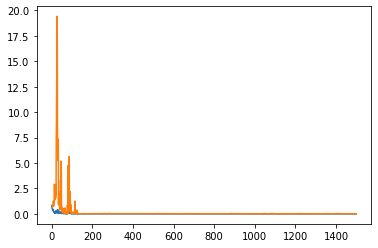

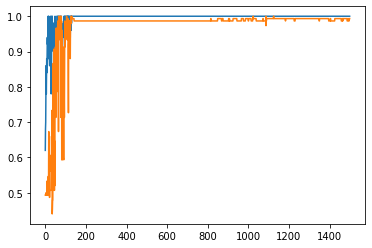

In [3]:
utils.save_model_stats(
    "ResNet",
    hist.history["loss"],
    hist.history["val_loss"],
    hist.history["accuracy"],
    hist.history["val_accuracy"],
    elapsed_time,
)

In [4]:
y_pred_test = model.predict(x=x_test)
y_pred_train = model.predict(x=x_train)

pd.DataFrame(y_pred_test, columns=["pred_proba1", "pred_proba2"]).to_csv("../data/ResNet/test_pred.csv", index=False)
pd.DataFrame(y_pred_train, columns=["pred_proba1", "pred_proba2"]).to_csv("../data/ResNet/train_pred.csv", index=False)